In [4]:
from pathlib import Path

from src.dino.opencv import read_image, write_image
from src.tone_mappers.bronto import bronto

CADIK_DIR = Path("cadik/tonemapped_images")
for image_dir in CADIK_DIR.iterdir():
    if not image_dir.is_dir():
        continue
    hdr_path = image_dir / f"{image_dir.stem}.hdr"
    print("Tonemapping", hdr_path, "using BRONTO...")
    image = read_image(str(hdr_path))
    bronto_tonemapped = bronto(image)
    output_path = str(image_dir / "bronto.png")
    write_image(output_path, bronto_tonemapped)
    print("Exported", output_path)

Tonemapping cadik/tonemapped_images/indoor/indoor.hdr using BRONTO...
Exported cadik/tonemapped_images/indoor/bronto.png
Tonemapping cadik/tonemapped_images/night/night.hdr using BRONTO...
Exported cadik/tonemapped_images/night/bronto.png
Tonemapping cadik/tonemapped_images/outdoor/outdoor.hdr using BRONTO...
Exported cadik/tonemapped_images/outdoor/bronto.png


In [5]:
import json
from pathlib import Path

import numpy as np
from tqdm.auto import tqdm

from src import dino

def MSE(img1, img2):
    assert img1.shape == img2.shape, f"{img1.shape} != {img2.shape}"
    return np.mean((img1 - img2) ** 2)

tonemapper_brightness_losses = {}
for image_name, (width, height) in [
    ("indoor", (600, 450)),
    ("outdoor", (600, 900)),
    ("night", (800, 533)),
]:
    directory = CADIK_DIR / image_name
    hdr_brightness = None
    tonemapper_losses = {}

    print(f"Calculating brightness response for {image_name} HDR image")
    for file in directory.iterdir():
        if file.suffix == ".hdr":
            image = dino.read_image(str(file))
            image = dino.resize_image(image, resize_width=width, resize_height=height)
            L = dino.rgb_to_relative_luminance(image)
            print("RMS luminance:", np.mean(L ** 2) ** (1/2))
            hdr_brightness = dino.dn_brightness_model(L)
            break
    print(f"Calculating brightness response for {image_name} tonemapped images")
    for file in tqdm([f for f in directory.iterdir() if f.suffix == ".png"], desc=image_name):
        image = dino.read_image(str(file))
        image = dino.resize_image(image, resize_width=width, resize_height=height)
        L = dino.rgb_to_relative_luminance(image) * 200 # screen white in nits
        tonemapped_brightness = dino.dn_brightness_model(L)
        tonemapper_losses[file.stem.lower()] = MSE(tonemapped_brightness, hdr_brightness)
    tonemapper_brightness_losses[image_name] = tonemapper_losses

# print(json.dumps(tonemapper_brightness_losses, indent=2))

Calculating brightness response for indoor HDR image
RMS luminance: 75.247734
Calculating brightness response for indoor tonemapped images


indoor:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating brightness response for outdoor HDR image
RMS luminance: 18.263773
Calculating brightness response for outdoor tonemapped images


outdoor:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating brightness response for night HDR image
RMS luminance: 65.17185
Calculating brightness response for night tonemapped images


night:   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
import pandas as pd

ranking_df = pd.read_csv("cadik/ranking_evaluation.csv", header=[0,1])
rating_df = pd.read_csv("cadik/rating_evaluation.csv", header=[0,1])

print(ranking_df)

         indoor                                                  outdoor  \
             tm brightness contrast details colours quality           tm   
0   ashikhmin02        8.3      8.0    10.2     8.3     7.6  ashikhmin02   
1        chiu93        1.1      2.7     3.0     1.1     1.8       chiu93   
2   choudhury03        5.2      5.9     7.0     5.4     2.2  choudhury03   
3          clip       10.6      7.6     7.6    11.3     8.9         clip   
4       drago03       10.9      9.5     6.9     9.0     8.9      drago03   
5      durand02        8.4      4.7     6.9     4.6     3.5     durand02   
6      fattal02        3.2      5.4     7.4     5.0     5.8     fattal02   
7        lcis99        4.1      6.2     5.4     3.4     4.6       lcis99   
8   pattanaik02       11.1      8.9    12.4     8.6     6.8  pattanaik02   
9    reinhard02       10.8     11.6    10.4    12.5    12.2   reinhard02   
10    schlick94        3.8      7.1     6.2     5.6     9.3    schlick94   
11    tumbli

In [ ]:
import matplotlib.pyplot as plt

images_in_order = {}

for image in ["indoor", "outdoor", "night"]:
    

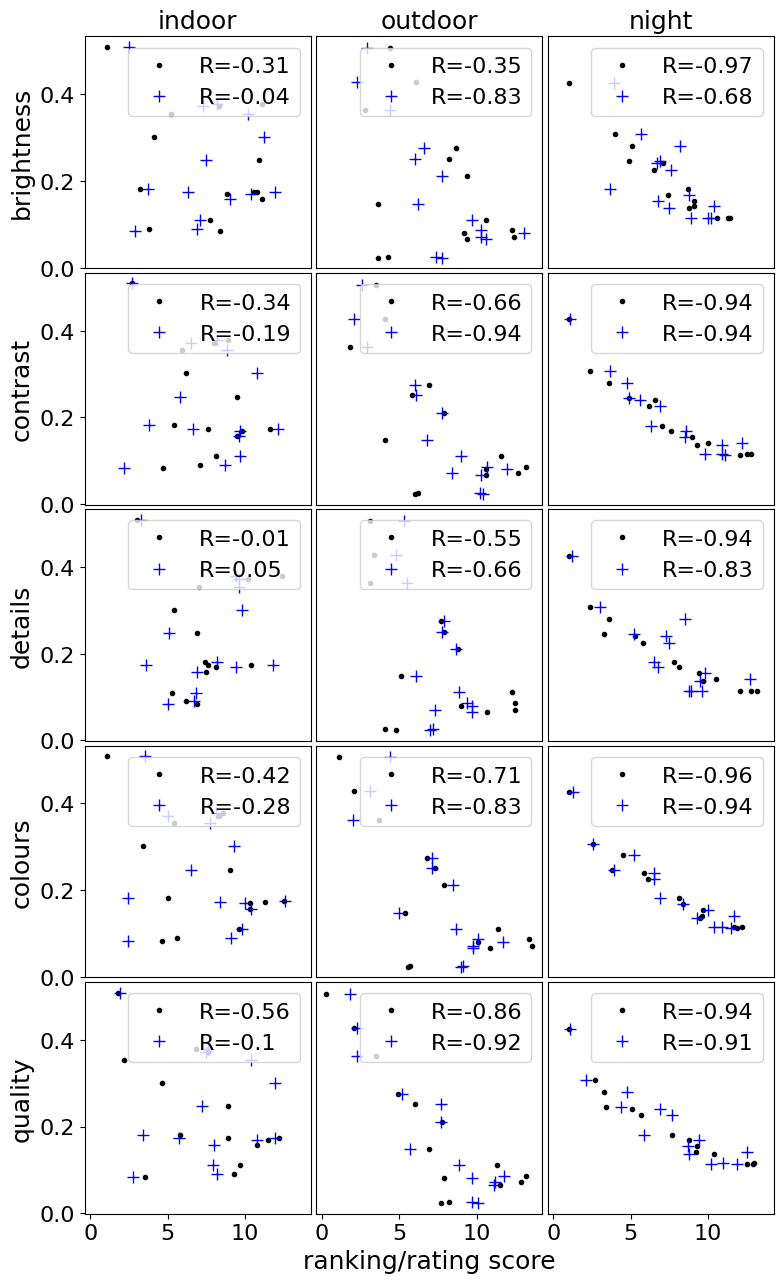

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import linregress

label_font_size = 18

ax_L = 2.5
fig, all_axs = plt.subplots(5, 3, figsize=(ax_L*3, ax_L*5), sharex=True, sharey=True)

for l, image_name in enumerate(["indoor", "outdoor", "night"]):
    scatter_per_category = defaultdict(lambda: [[],[]])
    for i, df in enumerate([ranking_df, rating_df]):
        df = df[image_name]
        for j in range(len(df)):
            tmo = df.iat[j, 0]
            for k, h in enumerate(df.columns):
                if k == 0:
                    continue
                scatter_per_category[h][i].append((df.iat[j, k], tonemapper_brightness_losses[image_name][tmo]))

    # print(scatter_per_category)
    axs = all_axs[:,l]
    axs[0].set_title(image_name, fontsize=label_font_size)
    for i, (category, datasets) in enumerate(scatter_per_category.items()):
        if l == 0:
            axs[i].set_ylabel(category, fontsize=label_font_size)
        if l == 1:
            axs[-1].set_xlabel("ranking/rating score", fontsize=label_font_size)

        ranking_data = datasets[0]
        rating_data = datasets[1]
        for label, data, plot_args, plot_kwargs in [
            ("ranking", ranking_data, ["k."], dict(markersize=6)),
            ("rating", rating_data, ["b+"], dict(markersize=8)),
        ]:
            x_data = [x[0] for x in data]
            y_data = [x[1] for x in data]
            result = linregress(x_data, y_data)
            formatted_label = f"R={round(result.rvalue, 2)}"
            axs[i].plot(x_data, y_data, *plot_args, label=formatted_label, **plot_kwargs)
        axs[i].legend(loc="upper right", fontsize=16)
    for ax in axs:
        ax.label_outer(remove_inner_ticks=True)
        ax.tick_params(axis="both", labelsize=16)

fig.tight_layout(pad=-0.5)
# fig.savefig("_output/cadik_rvalues.pdf", bbox_inches="tight")

In [ ]:
tm_ranking_dfs = {}

for image_name in ["indoor", "outdoor", "night"]:
    print(image_name)

    headers = ["dino"]
    # print("tone mappers ranked by brightness model:")
    dino = []
    # Ascending order, lower loss is better
    for i, (tm, _) in enumerate(sorted(tonemapper_brightness_losses[image_name].items(), key=lambda x: x[1])):
        # print(f"{i+1}. {tm}")
        dino.append(tm)

    cols = [dino]
    for df, name in [(ranking_df, "ranking"), (rating_df, "rating")]:
        for header in df[image_name].columns[1:]:
            # print(f"tone mappers ranked by Cadik {header} {name}:")
            ranking = []
            # Descending order, higher ranking is better
            for i, tm in enumerate(df.sort_values((image_name, header), ascending=False)[image_name]["tm"].to_list()):
                # print(f"{i+1}. {tm}")
                ranking.append(tm)
            cols.append(ranking)
            headers.append(f"{header}_{name}")

    tm_ranking_df = pd.DataFrame({h: col for h, col in zip(headers, cols, strict=True)})
    tm_ranking_df.to_csv(f"cadik/{image_name}_tm_ranking.csv")
    tm_ranking_dfs[image_name] = tm_ranking_df

In [ ]:
print(tm_ranking_dfs["outdoor"])

In [ ]:
from scipy.stats import kruskal


def key_sorted_values(dct, normalize=True):
    values = [dct[k] for k in sorted(dct.keys())]
    if normalize:
        max_value = max(*values)
        values = [v/max_value for v in values]
    return values

def key_positions(dct, reverse=False):
    positions = {k: i for i, (k, _) in enumerate(sorted(dct.items(), key=lambda x: x[1], reverse=reverse))}
    return [positions[k] for k in sorted(dct.keys())]

kruskal_results_dfs = {}

for image_name in ["indoor", "outdoor", "night"]:
    print(image_name)
    dino_ratings = tonemapper_brightness_losses[image_name]
    dino_ratings_list = key_positions(dino_ratings, reverse=False)
    df_data = {}
    for header in ranking_df[image_name].columns[1:]:
        rankings = ranking_df[image_name]
        ratings = rating_df[image_name]
        tm_rankings = {rankings.tm[i]: rankings[header][i] for i in range(len(ranking_df.index))}
        tm_ratings = {ratings.tm[i]: ratings[header][i] for i in range(len(rating_df.index))}
        assert len(tm_rankings) == len(tm_ratings)
        assert len(tm_rankings) == len(dino_ratings)
        tm_rankings_list = key_positions(tm_rankings, reverse=True)
        tm_ratings_list = key_positions(tm_ratings, reverse=True)
        statistic, p_value = kruskal(*list(zip(tm_rankings_list, tm_ratings_list)))
        kruskal_results = {"rating vs ranking": statistic}
        #kruskal_results = {"H (rating vs ranking)": statistic, "p (rating vs ranking)": p_value}
        statistic, p_value = kruskal(*list(zip(dino_ratings_list, tm_rankings_list)))
        kruskal_results["DINOS vs ranking"] = statistic
        #kruskal_results.update({"H (DINOS vs ranking)": statistic, "p (DINOS vs ranking)": p_value})
        statistic, p_value = kruskal(*list(zip(dino_ratings_list, tm_ratings_list)))
        kruskal_results["DINOS vs rating"] = statistic
        #kruskal_results.update({"H (DINOS vs rating)": statistic, "p (DINOS vs rating)": p_value})
        statistic, p_value = kruskal(*list(zip(dino_ratings_list, tm_rankings_list, tm_ratings_list)))
        kruskal_results["DINOS vs ranking vs rating"] = statistic
        #kruskal_results.update({"H (DINOS vs rating vs ranking)": statistic, "p (DINOS vs rating vs ranking)": p_value})
        df_data[header] = kruskal_results
    kruskal_results_dfs[image_name] = pd.DataFrame(df_data)

In [ ]:
for k, v in kruskal_results_dfs.items():
    print(k)
    print(v)
    print("")